# Process WCPDT and TCGA Data
Here we adapt and made some minor modifications to Aidan's peptide pipeline and apply it to the WCPDT dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pysam
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import gzip

## Basic Workflow Outline
1. Identify transcripts with scallop, ex: /rumi/shams/aidan/peptide/scripts/run_scallop.sh
2. Merge all identified transcripts (for each sample) into one file using gtfmerge union more info on gtf tools here 
3. Filter gtf of transcripts by RPKM with python function in notebook called filterGTFbyRPKM  (you can probs rewrite this better but as an example)
4. Optional (?): filter out peptides found in TCGA normal sample. We should ask Hani if you need to do this.
5. Convert gtf to fasta file using gffread , more info here.
6. Identify ORF/Kozak sequence from fasta seq with regex. Look at the beginning of this notebook: orphan_peptides_derisi_summary.ipynb  for getKozak  function and how its used.
7. Optional (?): Filter ORFs by alignment. So, you can also align ORFs (actually the peptides) against the proteome to filter out ORFs that are already annotated. Let me know when you get here and we can discuss.
8. Filter ORFs for the best Kozak scores. Look at this notebook for that: orphan_peptides_derisi_summary.ipynb
9. Filter ORFs by size. I did 20-5000 AA but look at what your distribution is.
10. Write final list of ORFs (filtered by: kozak score, size, alignment, etc.) to fasta for De Risi Lab

# Scallop 
Most time consuming/memory intensive step.

Run `scallop_call.sh` script. First time running it crashed for some reason. Need to rerun this whole process.

In [3]:
len([f for f in os.scandir("WCPDT_data/bam/") if f.name.endswith("bam")])

145

Some failed, probably due to memory allocation error (rumi ran out of RAM) for larger bam files.
<br> Error message:
<br> `terminate called after throwing an instance of 'std::bad_alloc'`

In [4]:
#Number of successful runs:
len([f for f in os.scandir("WCPDT_data/scallop_out/") if f.name.endswith("gtf")])

130

Actually not too bad only 15 failed, probably have Hani restart rumi and then I can run scallop again on these 15 files.

In [26]:
failed = []
success = set([f.name.split(".")[0] for f in os.scandir("WCPDT_data/scallop_out/") if f.name.endswith("gtf")])
for f in [f for f in os.scandir("WCPDT_data/bam/") if f.name.endswith("bam")]:
    if f.name.split(".")[0] not in success:
        failed.append(f.path)

In [27]:
failed

['WCPDT_data/bam/DTB-204-BL-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-002-BL-NS-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-146-BL-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-265-BL-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-187-BL-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-261-BL-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-053-BL-NS-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-111-BL-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-109-BL-T-RNA.bam',
 'WCPDT_data/bam/DTB-265-Pro-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-095-BL-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-083-BL-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-135-Pro-NS-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-085-BL-NS-T-RNA_new.bam',
 'WCPDT_data/bam/DTB-101-BL-T-RNA_new.bam']

Run `scallop_recall.sh` after rebooting rumi, clearing up more memory space.
<br>
Run was successful, moved all the results into WCPDT_data/scallop_out

# Merge Transcripts
### gtfmerge
Here we merge all the transcripts into a single gtf file. Note: the data from WCPDT are all metastatic samples.

In [2]:
with open("WCPDT_data/input_gtf.txt", "wt") as write:
    for f in os.scandir("WCPDT_data/scallop_out/"):
        write.write("/rumi/shams/jwang/People/DeRisi/" + f.path+"\n")

In [3]:
%%bash
/rumi/shams/jwang/bin/rnaseqtools-1.0.3/bin/./gtfmerge union input_gtf.txt WCPDT_data/merged_cancer.gtf -t 4 &> log/gtfmerge.out

### gffcompare

**First Filter**
<br>First layer of filters we eliminate transcripts found in the gencode basic annotation gtf.


In [4]:
%%bash
gffcompare -o gencode_comp -r WCPDT_data/gencode.v28.basic.annotation.gtf \
WCPDT_data/merged_cancer.gtf &> log/gffcompare1.out

In [5]:
%%bash
/rumi/shams/jwang/bin/rnaseqtools-1.0.3/bin/./gtfcuff puniq WCPDT_data/gencode_comp.merged_cancer.gtf.tmap \
WCPDT_data/merged_cancer.gtf WCPDT_data/gencode.v28.basic.annotation.gtf \
WCPDT_data/merged_cancer_filter_gencode.gtf &> log/gtfcuff1.out

**Second Filter**
<br>Second layer of filters we eliminate transcripts found in the merged normal gtf that Aidan created using TCGA data (normal samples from all tissue types)
<br> Aidan's merged normal gtf file name: `normal_merged_100925.gtf`
<br>Ran the below code in terminal

In [6]:
%%bash
gffcompare -o normal_comp -r WCPDT_data/normal_merged_190925.gtf WCPDT_data/merged_cancer_filter_gencode.gtf &> log/gffcompare2.out


In [7]:
%%bash
/rumi/shams/jwang/bin/rnaseqtools-1.0.3/bin/./gtfcuff puniq WCPDT_data/normal_comp.merged_cancer_filter_gencode.gtf.tmap \
WCPDT_data/merged_cancer_filter_gencode.gtf WCPDT_data/normal_merged_190925.gtf WCPDT_data/merged_cancer_filtered.gtf &> log/gtfcuff2.out


## Check GTF RPKM
We may need to filter our `merged_cancer_filtered.gtf` file which has been filtered against normal transcripts(that Aidan created in gtf form) and basic gencode transcript annotations. If number of Scallop-identified transcripts are too high, we will need to prioritize by RPKM.


In [2]:
!head WCPDT_data/merged_cancer_filtered.gtf

chr1	scallop	transcript	534803	634924	1000	+	.	gene_id "gene.10.225-x2-9"; transcript_id "gene.10.225.0-x2-9"; RPKM "1.3346"; cov "712.3420";
chr1	scallop	exon	534803	534879	1000	+	.	gene_id "gene.10.225-x2-9"; transcript_id "gene.10.225.0-x2-9"; exon "1"; 
chr1	scallop	exon	633888	634924	1000	+	.	gene_id "gene.10.225-x2-9"; transcript_id "gene.10.225.0-x2-9"; exon "2"; 
chr1	scallop	transcript	269222	634924	1000	+	.	gene_id "gene.10.225-x2-9"; transcript_id "gene.10.225.1-x2-9"; RPKM "0.4888"; cov "9.9097";
chr1	scallop	exon	269222	269249	1000	+	.	gene_id "gene.10.225-x2-9"; transcript_id "gene.10.225.1-x2-9"; exon "1"; 
chr1	scallop	exon	534869	534879	1000	+	.	gene_id "gene.10.225-x2-9"; transcript_id "gene.10.225.1-x2-9"; exon "2"; 
chr1	scallop	exon	633888	634924	1000	+	.	gene_id "gene.10.225-x2-9"; transcript_id "gene.10.225.1-x2-9"; exon "3"; 
chr1	scallop	transcript	673402	817605	1000	+	.	gene_id "gene.23.377-x0-0"; transcript_id "gene.23.377.0-x0-0"; RPKM "0.2273"; cov "2.8051"

In [3]:
#Just to show what we are doing with the filtering process.
with open("WCPDT_data/merged_cancer_filtered.gtf", "r") as orig:
    for line in orig:
        line_split = line.split("\t")
        if line_split[2] == "transcript":
            features = line_split[8]
            feat_split = features.split(";")
            rpkm = float(feat_split[2].split('"')[1])
            print(f"line split: {line_split} \n" )
            print(f"features split: {feat_split} \n")
            print(f"rpkm: {rpkm} \n")
        break

line split: ['chr1', 'scallop', 'transcript', '534803', '634924', '1000', '+', '.', 'gene_id "gene.10.225-x2-9"; transcript_id "gene.10.225.0-x2-9"; RPKM "1.3346"; cov "712.3420";\n'] 

features split: ['gene_id "gene.10.225-x2-9"', ' transcript_id "gene.10.225.0-x2-9"', ' RPKM "1.3346"', ' cov "712.3420"', '\n'] 

rpkm: 1.3346 



The range of rpkms is 0.045300 -- 12888.116200
9% of transcripts are included within the specified range: 0.500000 -- 7.000000
Total transcript number: 943453


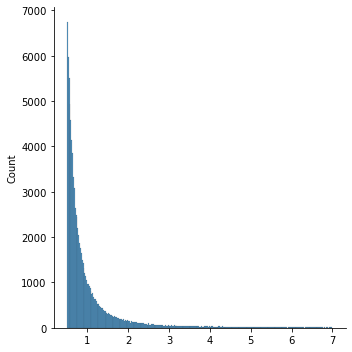

In [4]:
#Get coverage of our trimmed and filtered gtf:
rpkms = []
covs = []
with open("WCPDT_data/merged_cancer_filtered.gtf", 'r') as gtf:
    for line in gtf:
        line_split = line.split('\t')
        if(line_split[2] == 'transcript'):
            features = line_split[8]
            feat_split = features.split(';')
            rpkms.append(float(feat_split[2].split('"')[1]))
            covs.append(float(feat_split[3].split('"')[1]))
#Plot the coverage:
lower = 0.5
upper = 7

rpkm_range = [i for i in rpkms if i <= upper and i >= lower]
print('The range of %s is %f -- %f' % ("rpkms", min(rpkms), max(rpkms)))
print('%d%% of transcripts are included within the specified range: %f -- %f' % ((len(rpkm_range)/len(rpkms))*100,lower, upper))
print("Total transcript number:", len(rpkms))  
sns.displot(rpkm_range)

The range of rpkms is 0.045300 -- 12888.116200
82% of transcripts are included within the specified range: 0.100000 -- 0.700000


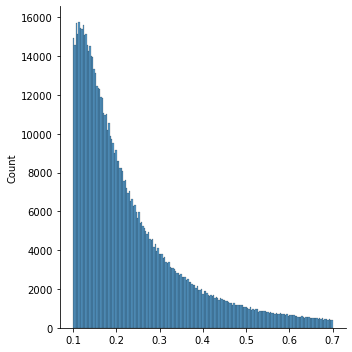

In [5]:
lower = 0.1
upper = 0.7

rpkm_range = [i for i in rpkms if i <= upper and i >= lower]
    
print('The range of %s is %f -- %f' % ("rpkms", min(rpkms), max(rpkms)))
print('%d%% of transcripts are included within the specified range: %f -- %f' % ((len(rpkm_range)/len(rpkms))*100,lower, upper))

sns.displot(rpkm_range)

Setting a cutoff of 2 is too high, we lose a lot of transcripts. Secondly, most of the "transcripts" identified are in the range of 0.1~0.7 rpkm. It seems to me that it would be okay to just use the unfiltered-by-RPKM gtf. Furthermore, total number of transcripts is only **943453**, which is definitely computationally feasible for running Salmon (for context Aidan's TCGA project on the other hand worked on the scale of 11,841,884 unfiltered. He cut it down to 573,422 using a RPKM cutoff of 2).

In [6]:
#Original pre-filtered number of transcipts.
rpkms = []
covs = []
with open("WCPDT_data/merged_cancer.gtf", 'r') as gtf:
    for line in gtf:
        line_split = line.split('\t')
        if(line_split[2] == 'transcript'):
            features = line_split[8]
            feat_split = features.split(';')
            rpkms.append(float(feat_split[2].split('"')[1]))
            covs.append(float(feat_split[3].split('"')[1]))
len(rpkms)

1534645

From our initial merged cancer gtf, we filtered out **591192 potential transcripts from 1534645 transcripts** using the normal gtf and the gencode annotation gtf to get a final amount of **943453**, corresponding to ~38.5% of the original transcripts filtered out.

### gffread
Next we run gffread to convert the gtf file into fasta. Again, we will be using the merged_cancer_filtered.gtf file instead of the RPKM trimmed version.

Initial run of gffread lead to error due to missing "chrUn" in our genome file. Here we first filter those lines out, creating a new gtf file call `new_merged_cancer_filtered.gtf`

In [7]:
num_un = 0
with open("WCPDT_data/merged_cancer_filtered.gtf", "r") as orig:
    for line in orig:
        if "chrUn" in line:
            num_un += 1
num_un

26875

In [8]:
with open("WCPDT_data/merged_cancer_filtered.gtf", "r") as orig:
    with open("WCPDT_data/new_merged_cancer_filtered.gtf", "w") as new:
        for line in orig:
            if "chrUn" in line:
                continue
            else:
                new.write(line)

In [9]:
#Sanity Check
new_num = 0
with open("WCPDT_data/new_merged_cancer_filtered.gtf", 'r') as gtf:
    for line in gtf:
        new_num += 1
orig_num = 0
with open("WCPDT_data/merged_cancer_filtered.gtf", 'r') as gtf:
    for line in gtf:
        orig_num += 1
orig_num - new_num

26875

In [10]:
%%bash
gffread WCPDT_data/new_merged_cancer_filtered.gtf -g /rumi/shams/genomes/hg38/hg38.fa -w WCPDT_data/final_merged_cancer.transcripts.fa \
&> log/gffread_final.out 

# Salmon: Transcript Quantification

### Create Salmon Index
We are not using salmon to its fullest capacity, primarily it selective alignment mode. To do so we need to first build an index that is decoy aware. Below we follow general good practice recommended by the Salmon folks.<br>

First we need to create a `decoy.txt file` based on the reference genome used. This file simply contains all the genome reference chromosome names.

In [41]:
%%bash
grep "^>" /rumi/shams/genomes/hg38/hg38.fa | cut -d " " -f 1 > WCPDT_data/decoys.txt
sed -i -e 's/>//g' WCPDT_data/decoys.txt

Next we concatenate the transcript and genome into a final merged transcript_genome file.

In [42]:
%%bash
cat WCPDT_data/final_merged_cancer.transcripts.fa /rumi/shams/genomes/hg38/hg38.fa  > WCPDT_data/hg38_gentrome.fa

Ran below command in `peptide` conda env:<br>
`salmon index -t WCPDT_data/hg38_gentrome.fa -d WCPDT_data/decoys.txt -p 20 -i WCPDT_data/final_merged_cancer_salmon_index -k 31 &> log/salmon_index.out`

This process allows us to use the entire genome of the organism as the decoy sequence. This scheme provides a more comprehensive set of decoys to eliminate spurious mappings.



## Run Salmon quant
Use samtools fasta to stream bamfiles into salmon quant.

### WCPDT
We run salmon quant script in `peptide` env, running 4 processes in parallel (each process using 4 threads), which will use up to 16 cores at once. Documentation for salmon 1.0.0+ versions seem to indicate that --validatemappings is the default mode.

Command: <br>
`ls /rumi/shams/jwang/People/DeRisi/WCPDT_data/bam/*.bam | parallel -j 4 bash scripts/salmon_quant.sh {} &> log/WCPDT_salmon_quant.out`

## Rerun Due to Server Shutdown

In [5]:
finished = [f.name[:-6] for f in os.scandir("/flash/jwang/DeRisi/salmon/") if f.name.endswith("quant") and "fail" not in f.name]
len(finished)

60

In [8]:
all_bam = [f for f in os.scandir("/rumi/shams/jwang/People/DeRisi/WCPDT_data/bam/") if f.name.endswith(".bam")]
len(all_bam)

145

In [10]:
with open("inputs/input_salmon.txt", "w") as out:
    for f in all_bam:
        name = f.name.split(".")[0]
        if name not in finished:
            out.write(f.path + "\n")

Rerun Command in `peptide` env: <br>
`cat inputs/input_salmon.txt | parallel -j 4 bash scripts/salmon_quant.sh {} &> log/WCPDT_salmon_quant_rerun.out`

# Done